In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import plotly.offline as pyo
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score 
from sklearn.metrics import silhouette_score
from IPython.display import Image
from sklearn.cluster import DBSCAN 
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import metrics
%matplotlib inline
pyo.init_notebook_mode()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
file_name = os.listdir("./output.parquet")[0]
shops = pd.read_parquet(f'./output.parquet/{file_name}')

In [3]:
def refresh_df():
    df_for_clustering = shops.copy()
    df_for_clustering = df_for_clustering.drop(df_for_clustering.loc[:,'neighborhood': 'location'].columns, 1)
    shop_ids = df_for_clustering.pop('shop_id')

    # Стандартизация
    scaler = StandardScaler()
    test_df_std = scaler.fit_transform(df_for_clustering)
    
    return df_for_clustering, test_df_std

In [4]:
# Dunn index
def dunn_index_eval(df_for_clustering):
    
    num_of_clusters = len(df_for_clustering.Cluster.unique())
    clust_names = df_for_clustering.Cluster.unique().tolist()
    cluster_list = []
    
    for clust_name in clust_names:
        cluster = df_for_clustering.loc[df_for_clustering.Cluster == clust_name] 
        cluster_list.append(cluster.values)
        
    return metrics.dunn(cluster_list)

In [5]:
def saving_results(df_for_clustering, method: str):
    
    shops_with_cluster = df_for_clustering.join(shops['shop_id'])
    shops_with_cluster = shops_with_cluster.loc[:,'Cluster':]
    shops_with_cluster.to_csv(f'./Clustering_results/{method}.tsv', sep='\t', index=False)   
    
    return 'Done'

# PCA

In [6]:
def pca_plot(test_df_std):
    pca = PCA(n_components=min(10, test_df_std.shape[1]))
    pca.fit(test_df_std)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)
    plt.figure(figsize=(10,6))
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.plot(var)
    plt.show()

In [7]:
def pca_eval(test_df_std, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(test_df_std)
    pca_scale = pca.transform(test_df_std)
    pca_df = pd.DataFrame(pca_scale, columns=['pc'+str(i) for i in range(1, n_components+1)])

    print(pca.explained_variance_ratio_)
    
    return pca_df

## Построение дерева принятия решений для оценки влияния факторов при разделении на кластеры

In [8]:
def decision_tree_eval(df_for_clustering, class_names):
    X = df_for_clustering.iloc[:,:260]
    Y = df_for_clustering.iloc[:,260:]
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.33, random_state=42)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    tree = DecisionTreeClassifier(random_state=42, min_samples_split=3)
    tree.fit(X_train, Y_train)
    dot_data = export_graphviz(tree, out_file=None,
                               feature_names=X.columns,
                               class_names=class_names,
                               filled=True,
                               rounded=True,
                               special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    display(Image(graph.create_png()))
    
    print('tree.score = ', tree.score(X_test, Y_test))
    # Важность признаков при делении на кластеры в дереве решений
    f = []
    for features, sc in zip(X.columns, tree.feature_importances_):
        if sc!= 0:
            print(features, sc)
            f.append(features)
    
    return f

# Кластеризация

### K - means

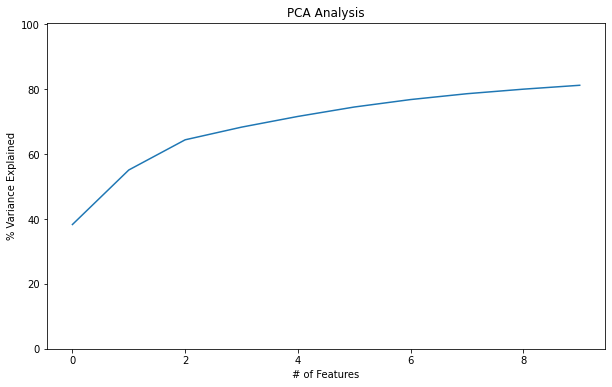

In [9]:
df_for_clustering, test_df_std = refresh_df()
pca_plot(test_df_std)

In [10]:
# оставляем три компоненты
pca_df = pca_eval(test_df_std,3)

[0.38260697 0.1683812  0.09256167]


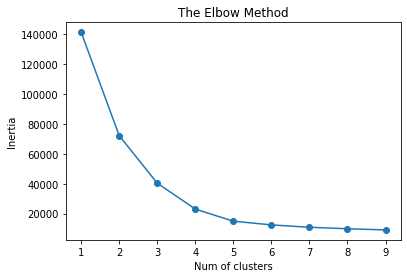

In [11]:
from sklearn.cluster import KMeans

# Тренировка моделей
K = range(1,10)
models = [KMeans(n_clusters=k,random_state=42).fit(pca_df) for k in K]
dist = [model.inertia_ for model in models]

# Каменистая осыпь
plt.plot(K,dist,marker="o")
plt.xlabel('Num of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

In [12]:
# Как поделились магазины на 3 кластера
df_for_clustering["Cluster"] = pd.Series(models[2].labels_,index=df_for_clustering.index)
display(df_for_clustering.groupby("Cluster").median())

# Сколько магазинов в каждом кластере
display(df_for_clustering.groupby("Cluster").size())

Бензак_10month  Бензак_11month  Бензак_12month  Бензак_1month  Бензак_2month  Бензак_3month  Бензак_4month  Бензак_5month  Бензак_6month  Бензак_7month  Бензак_8month  Бензак_9month  Броня и одежда_10month  Броня и одежда_11month  Броня и одежда_12month  Броня и одежда_1month  Броня и одежда_2month  Броня и одежда_3month  Броня и одежда_4month  Броня и одежда_5month  Броня и одежда_6month  Броня и одежда_7month  Броня и одежда_8month  Броня и одежда_9month  Жидкости для тачки_10month  Жидкости для тачки_11month  Жидкости для тачки_12month  Жидкости для тачки_1month  Жидкости для тачки_2month  Жидкости для тачки_3month  Жидкости для тачки_4month  Жидкости для тачки_5month  Жидкости для тачки_6month  Жидкости для тачки_7month  Жидкости для тачки_8month  Жидкости для тачки_9month  Медпрепараты и еда_10month  Медпрепараты и еда_11month  Медпрепараты и еда_12month  Медпрепараты и еда_1month  Медпрепараты и еда_2month  Медпрепараты и еда_3month  Медпрепараты и еда_4month  \
Cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
0              0.094209        0.093848        0.092027       0.085979       0.085210       0.085481       0.087976       0.091123       0.092221       0.094118       0.095128       0.093587                0.180159                0.182018                0.180117               0.192931               0.189953               0.195926               0.186513               0.172448               0.167697               0.165122               0.175320               0.181520                    0.015361                    0.019884                    0.018241                   0.015955                   0.014720                   0.017012                   0.007799                   0.005431                   0.006019                   0.005935                   0.006030                   0.008209                    0.034889                    0.033839                    0.033194                   0.032102                    0.03219                   0.031789                    0.03384   
1              0.128509        0.128431        0.132507       0.125172       0.123550       0.119748       0.121051       0.124922       0.125918       0.130385       0.132828       0.128626                0.241538                0.239694                0.237271               0.253469               0.250375               0.250738               0.254434               0.244928               0.247617               0.246435               0.244695               0.247868                    0.013125                    0.015158                    0.008541                   0.005959                   0.007608                   0.013281                   0.005198                   0.002718                   0.003141                   0.003401                   0.003596                   0.005411                    0.000000                    0.000000                    0.000000                   0.000000                    0.00000                   0.000000                    0.00000   
2              0.634573        0.631118  

Cluster
0    548
1    208
2     89
dtype: int64

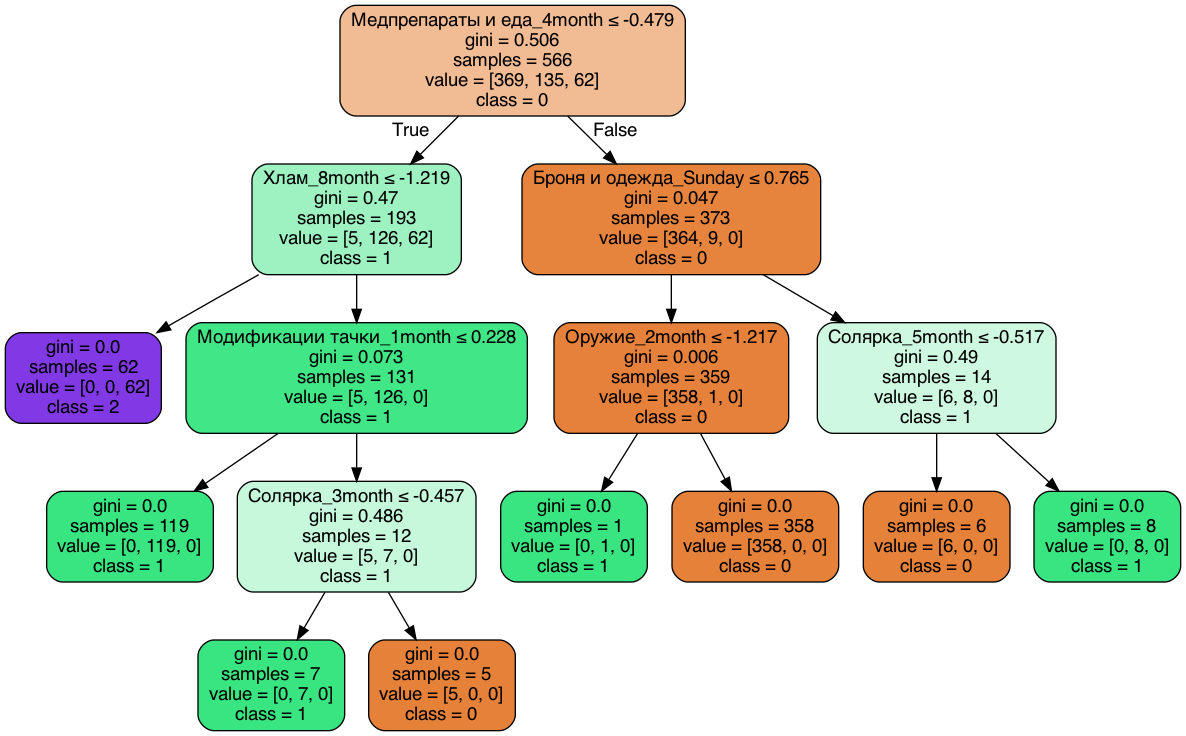

tree.score =  0.974910394265233
Медпрепараты и еда_4month 0.6220522862652259
Модификации тачки_1month 0.013213813940898956
Оружие_2month 0.006962774611458807
Солярка_3month 0.020364819132444312
Солярка_5month 0.02393905269446515
Хлам_8month 0.2830453143087191
Броня и одежда_Sunday 0.03042193904678774


In [13]:
# дерево решений для k-means
f = decision_tree_eval(df_for_clustering, ['0', '1', '2'])

### Анализ главных компонент только по значимым фичам для k-means

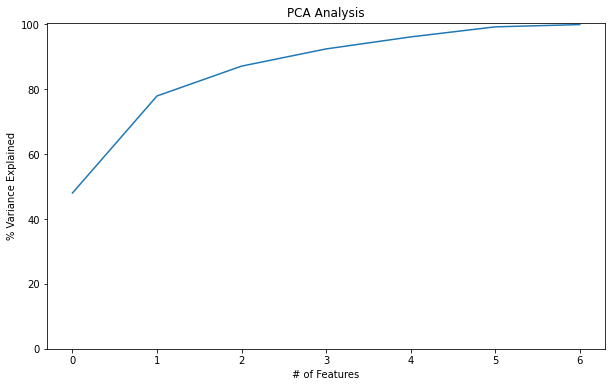

In [14]:
df_for_clustering, test_df_std = refresh_df()
df_for_clustering = df_for_clustering[f]
test_df_std = StandardScaler().fit_transform(df_for_clustering)
pca_plot(test_df_std)

In [15]:
pca_df = pca_eval(test_df_std, 2)

[0.48008899 0.29867884]


In [16]:
# Тренировка моделей
K = range(1,10)
models = [KMeans(n_clusters=k,random_state=42).fit(pca_df) for k in K]
dist = [model.inertia_ for model in models]

# Как поделились магазины на 3 кластера
df_for_clustering["Cluster"] = pd.Series(models[2].labels_,index=df_for_clustering.index)
display(df_for_clustering.groupby("Cluster").median())

# Сколько магазинов в каждом кластере
display(df_for_clustering.groupby("Cluster").size())

Медпрепараты и еда_4month  Модификации тачки_1month  Оружие_2month  Солярка_3month  Солярка_5month  Хлам_8month  Броня и одежда_Sunday
Cluster                                                                                                                                        
0                         0.000000                  0.028817        0.00000        0.073100        0.070103     0.048596               0.240225
1                         0.000000                  0.000000        0.00000        0.360199        0.390367     0.000000               0.000000
2                         0.034033                  0.105426        0.08488        0.067081        0.063440     0.036718               0.181931

Cluster
0    234
1     75
2    536
dtype: int64

In [17]:
# Расчет метрик
print('Dunn index: ',dunn_index_eval(df_for_clustering),
      '\nDavies bouldin', davies_bouldin_score(df_for_clustering, df_for_clustering['Cluster'].values),
      '\nSilhouette', silhouette_score(df_for_clustering.drop("Cluster",axis=1),
                                      df_for_clustering['Cluster']))

Dunn index:  1.1997795998635714 
Davies bouldin 0.19987306630713245 
Silhouette 0.382607069239925


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



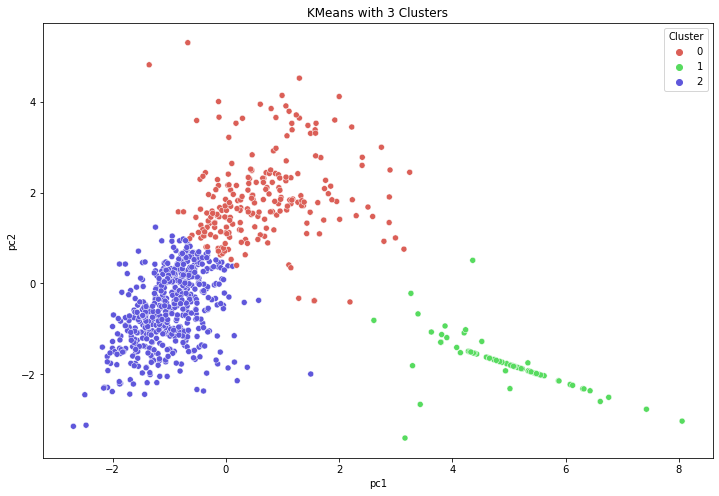

In [18]:
plt.figure(figsize=(12, 8))
sns.scatterplot(pca_df['pc1'],
                pca_df['pc2'],
                hue=df_for_clustering['Cluster'], 
                palette=sns.color_palette('hls', 3))
plt.title('KMeans with 3 Clusters')
plt.show()

In [19]:
# Запись результатов в файл
saving_results(df_for_clustering, 'k_means')

'Done'

# _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

## Agglomerative

In [20]:
# обновление данных
df_for_clustering, test_df_std = refresh_df()

In [21]:
from sklearn.cluster import AgglomerativeClustering 

agglom = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(test_df_std)

df_for_clustering['Cluster'] = agglom.labels_

# Сколько магазинов в каждом кластере
display(df_for_clustering.groupby("Cluster").size())

# Как поделились магазины на 3 кластера
df_for_clustering["Cluster"] = pd.Series(agglom.labels_,index=df_for_clustering.index)
df_for_clustering.groupby("Cluster").median()

Cluster
0    690
1     89
2     66
dtype: int64

Бензак_10month  Бензак_11month  Бензак_12month  Бензак_1month  Бензак_2month  Бензак_3month  Бензак_4month  Бензак_5month  Бензак_6month  Бензак_7month  Бензак_8month  Бензак_9month  Броня и одежда_10month  Броня и одежда_11month  Броня и одежда_12month  Броня и одежда_1month  Броня и одежда_2month  Броня и одежда_3month  Броня и одежда_4month  Броня и одежда_5month  Броня и одежда_6month  Броня и одежда_7month  Броня и одежда_8month  Броня и одежда_9month  Жидкости для тачки_10month  Жидкости для тачки_11month  Жидкости для тачки_12month  Жидкости для тачки_1month  Жидкости для тачки_2month  Жидкости для тачки_3month  Жидкости для тачки_4month  Жидкости для тачки_5month  Жидкости для тачки_6month  Жидкости для тачки_7month  Жидкости для тачки_8month  Жидкости для тачки_9month  Медпрепараты и еда_10month  Медпрепараты и еда_11month  Медпрепараты и еда_12month  Медпрепараты и еда_1month  Медпрепараты и еда_2month  Медпрепараты и еда_3month  Медпрепараты и еда_4month  \
Cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
0              0.094280        0.094034        0.092325       0.086308       0.085210       0.085481       0.087749       0.091123       0.092159       0.094551       0.095280       0.094103                0.190110                0.190560                0.188097               0.201719               0.198407               0.203077               0.196458               0.182306               0.177024               0.176175               0.185785               0.191644                    0.014598                    0.018894                    0.015801                   0.013474                   0.013092                   0.016241                   0.007179                   0.005029                   0.005510                   0.005542                   0.005646                   0.007810                    0.029727                    0.028608                    0.028017                   0.027975                   0.027501                   0.026863                   0.028765   
1              0.634573        0.631118        0.636454       0.607946       0.610267       0.613238       0.618540       0.614978       0.633229       0.634096       0.637345       0.636901                0.000000                0.000000                0.000000               0.000000               0.000000               0.000000               0.000000               0.000000               0.000000               0.000000               0.000000               0.000000                    0.000000                    0.000000                    0.000000                   0.000000                   0.000000                   0.000000                   0.000000                   0.000000                   0.000000                   0.000000                   0.000000                   0.000000                    0.000000                    0.000000                    0.000000                   0.000000                   0.000000                   0.000000                   0.000000   
2              0.272045        0.277232  

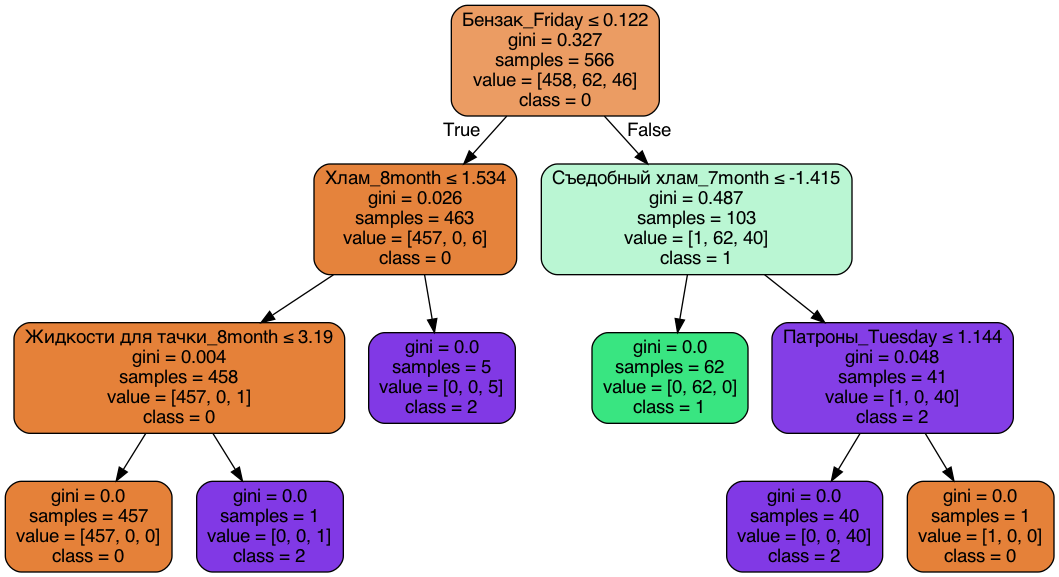

tree.score =  0.989247311827957
Жидкости для тачки_8month 0.01079524795740771
Съедобный хлам_7month 0.260652016543051
Хлам_8month 0.053276763677486835
Бензак_Friday 0.6647209767545565
Патроны_Tuesday 0.010554995067497892


In [22]:
f = decision_tree_eval(df_for_clustering, ['0', '1', '2'])

### Agglomerative только со значимыми фичами

In [23]:
df_for_clustering, test_df_std = refresh_df()
df_for_clustering = df_for_clustering[f]
test_df_std = StandardScaler().fit_transform(df_for_clustering)

agglom = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(test_df_std)

df_for_clustering['Cluster'] = agglom.labels_

# Сколько магазинов в каждом кластере
display(df_for_clustering.groupby("Cluster").size())

# Как поделились магазины на 3 кластера
df_for_clustering["Cluster"] = pd.Series(agglom.labels_,index=df_for_clustering.index)
df_for_clustering.groupby("Cluster").median()

Cluster
0    701
1     89
2     55
dtype: int64

Жидкости для тачки_8month  Съедобный хлам_7month  Хлам_8month  Бензак_Friday  Патроны_Tuesday
Cluster                                                                                               
0                         0.005686               0.070526     0.038488       0.087600         0.217766
1                         0.000000               0.000000     0.000000       0.643109         0.000000
2                         0.002461               0.082463     0.099854       0.264008         0.000000

In [24]:
# считаем метрики
print('Dunn index: ',dunn_index_eval(df_for_clustering),
      '\nDavies bouldin', davies_bouldin_score(df_for_clustering, df_for_clustering['Cluster'].values),
      '\nSilhouette', silhouette_score(df_for_clustering.drop("Cluster",axis=1),
                                      df_for_clustering['Cluster']))
      

Dunn index:  1.3521707741335982 
Davies bouldin 0.2099966064773088 
Silhouette 0.6002567071993249


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



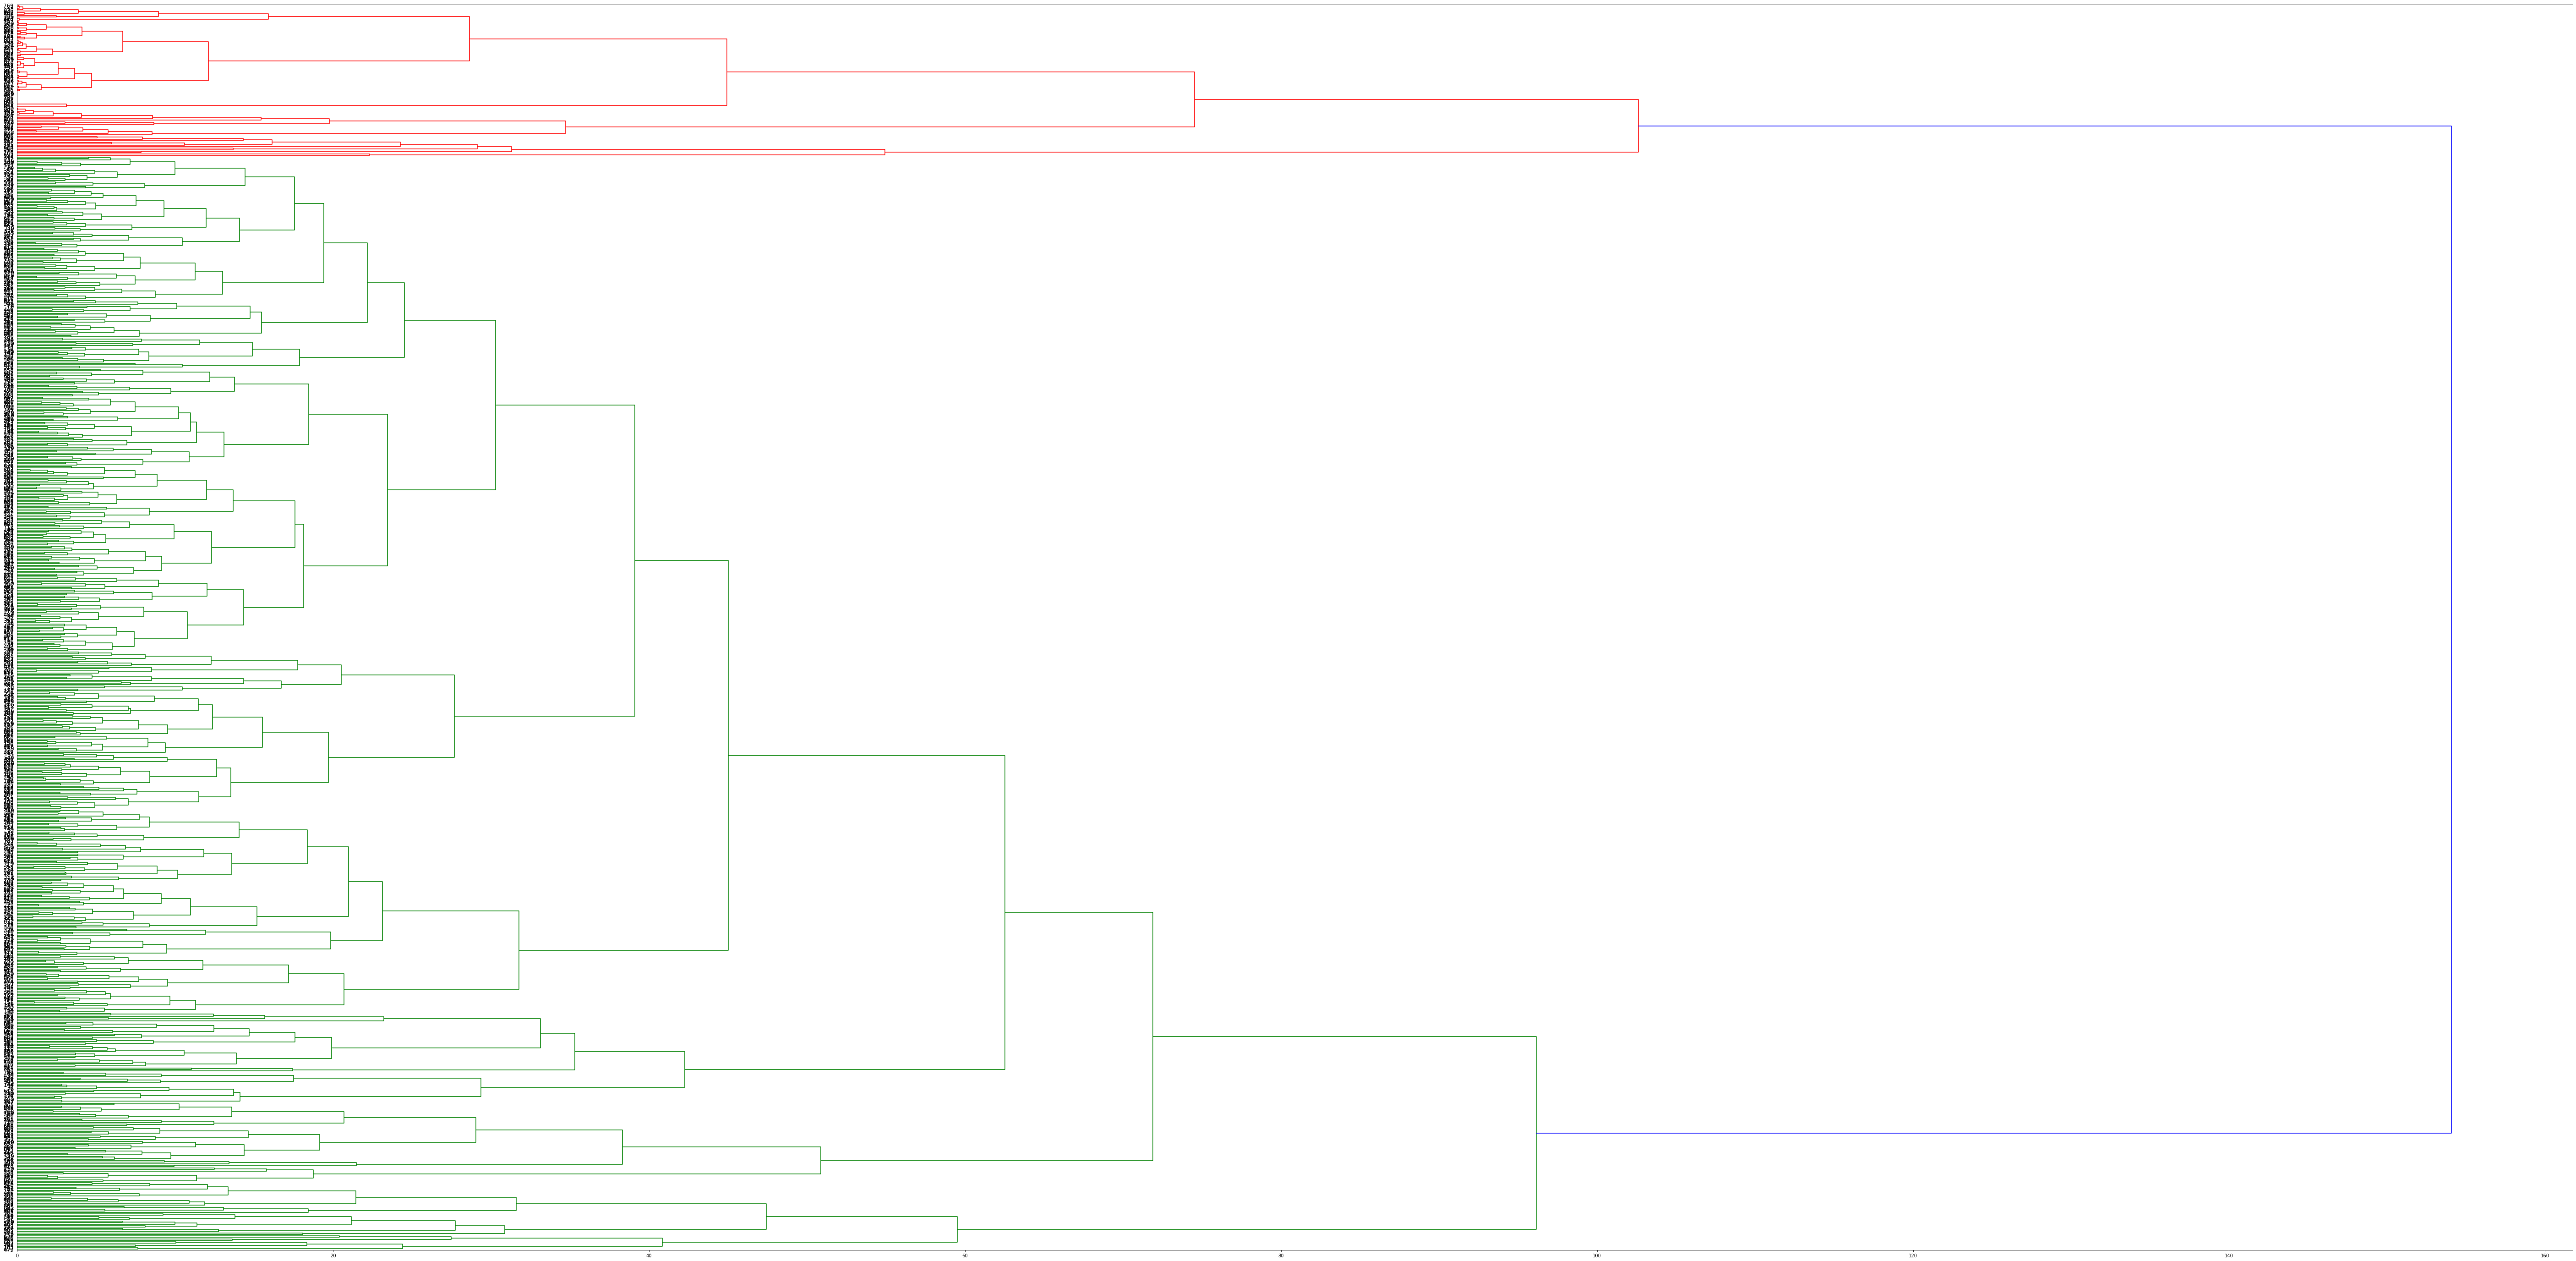

In [25]:
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 

dist = distance_matrix(test_df_std, test_df_std)

plt.figure(figsize=(100, 50))
Z = hierarchy.linkage(dist, 'complete')
dendro = hierarchy.dendrogram(Z, leaf_rotation=0, leaf_font_size=12, orientation='right')

In [26]:
# Запись результатов в файл
saving_results(df_for_clustering, 'agglomerative')

'Done'

# _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

## Density Based Clustering (DBSCAN)

In [27]:
df_for_clustering, test_df_std = refresh_df()
pca_df = pca_eval(test_df_std,3)

[0.38260697 0.1683812  0.09256167]


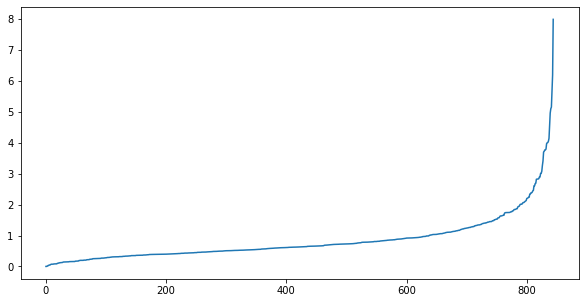

In [28]:
# определяем эпсилон с помощью KNN
plt.figure(figsize=(10,5))
nn = NearestNeighbors(n_neighbors=5).fit(pca_df)
distances, idx = nn.kneighbors(pca_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.show()

In [29]:
db = DBSCAN(eps=5, min_samples=6).fit(pca_df)
df_for_clustering["Cluster"] = pd.Series(db.labels_,index=df_for_clustering.index)

# Сколько магазинов в каждом кластере
display(df_for_clustering.groupby("Cluster").size())
display(df_for_clustering.groupby("Cluster").median())

print("Silhouette Coefficient: %0.3f" %silhouette_score(pca_df, df_for_clustering['Cluster']))

Cluster
-1     10
 0    692
 1     89
 2     54
dtype: int64

Бензак_10month  Бензак_11month  Бензак_12month  Бензак_1month  Бензак_2month  Бензак_3month  Бензак_4month  Бензак_5month  Бензак_6month  Бензак_7month  Бензак_8month  Бензак_9month  Броня и одежда_10month  Броня и одежда_11month  Броня и одежда_12month  Броня и одежда_1month  Броня и одежда_2month  Броня и одежда_3month  Броня и одежда_4month  Броня и одежда_5month  Броня и одежда_6month  Броня и одежда_7month  Броня и одежда_8month  Броня и одежда_9month  Жидкости для тачки_10month  Жидкости для тачки_11month  Жидкости для тачки_12month  Жидкости для тачки_1month  Жидкости для тачки_2month  Жидкости для тачки_3month  Жидкости для тачки_4month  Жидкости для тачки_5month  Жидкости для тачки_6month  Жидкости для тачки_7month  Жидкости для тачки_8month  Жидкости для тачки_9month  Медпрепараты и еда_10month  Медпрепараты и еда_11month  Медпрепараты и еда_12month  Медпрепараты и еда_1month  Медпрепараты и еда_2month  Медпрепараты и еда_3month  Медпрепараты и еда_4month  \
Cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
-1             0.280922        0.275424        0.289993       0.369010       0.353869       0.334038       0.320788       0.325047       0.291411       0.303619       0.318829       0.289655                0.111368                0.058481                0.095221               0.155665               0.135225               0.138163               0.090634               0.092199               0.155577               0.096054               0.113729               0.121900                    0.014591                    0.022038                    0.022630                   0.023377                   0.019413                   0.017856                   0.006944                   0.003303                   0.006581                   0.004881                   0.005965                   0.005399                    0.000000                    0.000000                    0.000000                   0.000000                    0.00000                   0.000000                   0.000000   
 0             0.094369        0.094122        0.092362       0.086520       0.085347       0.085531       0.087851       0.091214       0.092190       0.094715       0.095335       0.094223                0.190133                0.190824                0.188153               0.202275               0.198520               0.203193               0.196877               0.182798               0.177394               0.176350               0.185951               0.191963                    0.014598                    0.018894                    0.015801                   0.013474                   0.013092                   0.016241                   0.007179                   0.005029                   0.005510                   0.005542                   0.005646                   0.007810                    0.029705                    0.028557                    0.027957                   0.027945                    0.02741                   0.026823                   0.028745   
 1             0.634573        0.631118  

Silhouette Coefficient: 0.559


In [30]:
# как разделились кластеры
Scene = dict(xaxis = dict(title  = 'PC1'),yaxis = dict(title  = 'PC2'),zaxis = dict(title  = 'PC3'))
labels = db.labels_
trace = go.Scatter3d(x=pca_df.iloc[:,0], y=pca_df.iloc[:,1], z=pca_df.iloc[:,2], mode='markers',marker=dict(color = labels, colorscale='Viridis', size = 10, line = dict(color = 'gray',width = 5)))
layout = go.Layout(scene = Scene, height = 1000,width = 1000)
data = [trace]
fig = go.Figure(data = data, layout = layout)
fig.update_layout(title='DBSCAN clusters (3) Derived from PCA', font=dict(size=12,))
fig.show()

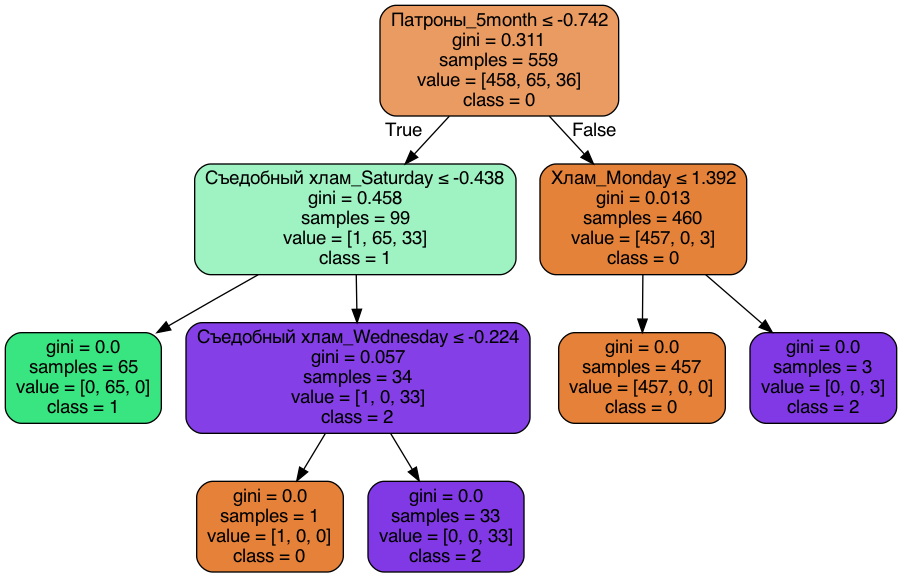

tree.score =  0.9818840579710145
Патроны_5month 0.7051096085127279
Съедобный хлам_Saturday 0.24944362686717128
Съедобный хлам_Wednesday 0.011164221233989293
Хлам_Monday 0.03428254338611165


In [31]:
f = decision_tree_eval(df_for_clustering.loc[df_for_clustering.Cluster >=0], [ '0', '1', '2'])

In [32]:
# Запись результатов в файл
saving_results(df_for_clustering, 'DBSCAN')

'Done'

### Варьирование параметров DBSCAN

In [33]:
df_for_clustering, test_df_std = refresh_df()
pca_df = pca_eval(test_df_std,3)

[0.38260697 0.1683812  0.09256167]


In [34]:
best_params = None
best_metric = float("-inf")
best_model = None

for samples in range(1, 10):
    for eps_ in range(1,30):
        db = DBSCAN(eps=eps_, min_samples=samples).fit(pca_df)
        df_for_clustering['Cluster'] = db.labels_

        num_of_clusters = len(df_for_clustering.Cluster.unique())
        if num_of_clusters > 3 and num_of_clusters <=6:
        
            print(f"eps_: {eps_}, samples: {samples}")
            metric = silhouette_score(df_for_clustering.drop("Cluster",axis=1),
                                      df_for_clustering['Cluster'])
            print(metric)


            if metric > best_metric:
                best_metric = metric
                best_params = [samples, eps_]
                best_model = db

    print("#"*60)

eps_: 6, samples: 1
-0.09403244274689115
############################################################
############################################################
eps_: 3, samples: 3
-0.17269016095770726
eps_: 4, samples: 3
-0.12347201832231493
############################################################
eps_: 2, samples: 4
-0.030944904418714742
eps_: 3, samples: 4
0.0008760797200559723
eps_: 4, samples: 4
-0.1228601301213347
############################################################
eps_: 2, samples: 5
0.008524893543813162
eps_: 3, samples: 5
0.0038338810291159396
eps_: 4, samples: 5
0.035737106681552354
############################################################
eps_: 2, samples: 6
0.008004688777262469
eps_: 3, samples: 6
0.005661729477133655
eps_: 4, samples: 6
0.029727486735861067
eps_: 5, samples: 6
0.014739836034464387
############################################################
eps_: 2, samples: 7
-0.04963397702813549
eps_: 3, samples: 7
0.0628843085654549
eps_: 4, samples: 7

# Сравнение полученных кластеров 

In [35]:
k_means = pd.read_csv('./Clustering_results/k_means.tsv', sep='\t')
agglo = pd.read_csv('./Clustering_results/agglomerative.tsv', sep='\t')
dbscan = pd.read_csv('./Clustering_results/DBSCAN.tsv', sep='\t')

In [36]:
def generator_clusters(k_means, agglo, dbscan):
    list_of_clusters = [k_means, agglo, dbscan]
    
    result = []
    for table in list_of_clusters:
        val = []
        for cluster in range(3):
            k = table['shop_id'].loc[table.Cluster == cluster].tolist()
            val.append(k)
        result.append(val)
            
    return result

In [37]:
result = generator_clusters(k_means, agglo, dbscan)

In [38]:
# k_means VS agglo
print('\t\tk_means VS agglo\n')
print('Размеры кластеров: ', len(result[0][0]), ', ', len(result[1][2]),
    '\nПересечения:', len(list(set(result[0][0]) & set(result[1][2]))),
     '\n\n')

print('Размеры кластеров: ', len(result[0][1]), ', ', len(result[1][1]),
    '\nПересечения:', len(list(set(result[0][1]) & set(result[1][1]))),
     '\n\n')


print('Размеры кластеров: ', len(result[0][2]), ', ', len(result[1][0]),
    '\nПересечения:', len(list(set(result[0][2]) & set(result[1][0]))))

		k_means VS agglo

Размеры кластеров:  234 ,  55 
Пересечения: 53 


Размеры кластеров:  75 ,  89 
Пересечения: 74 


Размеры кластеров:  536 ,  701 
Пересечения: 535


In [39]:
# k_means VS DBSCAN
print('\t\tk_means VS DBSCAN\n')
print('Размеры кластеров: ', len(result[0][0]), ', ', len(result[2][0]),
    '\nПересечения:', len(list(set(result[0][0]) & set(result[2][0]))),
     '\n\n')

print('Размеры кластеров: ', len(result[0][1]), ', ', len(result[2][1]),
    '\nПересечения:', len(list(set(result[0][1]) & set(result[2][1]))),
     '\n\n')


print('Размеры кластеров: ', len(result[0][2]), ', ', len(result[2][2]),
    '\nПересечения:', len(list(set(result[0][2]) & set(result[2][2]))))

		k_means VS DBSCAN

Размеры кластеров:  234 ,  692 
Пересечения: 156 


Размеры кластеров:  75 ,  89 
Пересечения: 74 


Размеры кластеров:  536 ,  54 
Пересечения: 0


In [40]:
# agglo VS DBSCAN
print('\t\tagglo VS DBSCAN\n')
print('Размеры кластеров: ', len(result[1][2]), ', ', len(result[2][0]),
    '\nПересечения:', len(list(set(result[1][2]) & set(result[2][0]))),
     '\n\n')

print('Размеры кластеров: ', len(result[1][1]), ', ', len(result[2][1]),
    '\nПересечения:', len(list(set(result[1][1]) & set(result[2][1]))),
     '\n\n')


print('Размеры кластеров: ', len(result[1][0]), ', ', len(result[2][2]),
    '\nПересечения:', len(list(set(result[1][0]) & set(result[2][2]))))

		agglo VS DBSCAN

Размеры кластеров:  55 ,  692 
Пересечения: 1 


Размеры кластеров:  89 ,  89 
Пересечения: 89 


Размеры кластеров:  701 ,  54 
Пересечения: 7
